In [1]:
import numpy as np
np.set_printoptions(precision=3)
import scipy
import scipy.ndimage
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage
import skimage.feature
import time

In [2]:
def load_image(path):
    im = cv2.imread(path, 0)
    im = im / 255.
    return im

In [3]:
def blob_detector(image, stds, threshold, k, method):
    (h,w) = image.shape
    #stds = [2 * (1.1 ** i) for i in range(15)]
    scale_space = np.zeros((h,w,len(stds)))
    
    if (method == 'increase_filter'):
        for i in range(len(stds)):
            std = stds[i]
            scale_space[:,:,i] = ((std ** 2) * (scipy.ndimage.filters.gaussian_laplace(image, std))) ** 2
    elif (method == 'downsample'):
        resize_frac = 1.0
        for i in range(len(stds)):
            std = stds[0]
            stds[i] = std * (k ** i)
            downsampled_im = skimage.transform.resize(image, (int(h*resize_frac), int(w*resize_frac)))
            convolve_out = scipy.ndimage.filters.gaussian_laplace(downsampled_im, std) ** 2
            scale_space[:,:,i] = skimage.transform.resize(convolve_out, (h,w))
            resize_frac *= (1/k)
            
        

    max_vals = np.zeros(scale_space.shape)
    for i in range(len(stds)):
        level = scale_space[:,:,i]
        max_filter = scipy.ndimage.filters.rank_filter(level, -1, size=int(stds[i]*2))
        max_indices = (level == max_filter).nonzero()
        max_vals[:,:,i][max_indices] = level[max_indices]
    
    max_vals_final = np.zeros(max_vals.shape)
    count = 4
    offset = 2
    for i in range(count+offset, len(stds)-count):
        level = max_vals[:,:,i-count:i+count]
        max_filter = scipy.ndimage.filters.rank_filter(level, -1, size=(int(stds[i+count-1]), int(stds[i+count-1]), 2*count+1))
        max_indices = (level == max_filter).nonzero()
        max_vals_final[:,:,i-count:i+count][max_indices] = level[max_indices]
    
    max_vals = max_vals_final
    max_vals_condensed = np.max(max_vals, 2)
    max_indices_condensed = np.argmax(max_vals, 2)
    max_indices_condensed *= (max_vals_condensed > threshold)
    max_vals_condensed *= (max_vals_condensed > threshold)
    
    return max_indices_condensed

In [37]:
def show_all_circles(image, cx, cy, rad, image_name, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    cv2.imsave(image_name[:-4] + "_keypoints" + ".png", data)
    
    plt.show()
    
    
    

Inefficient version on image assignment2_images/butterfly.jpg ran in 0.537595 seconds.


AttributeError: 'FigureCanvasAgg' object has no attribute 'renderer'

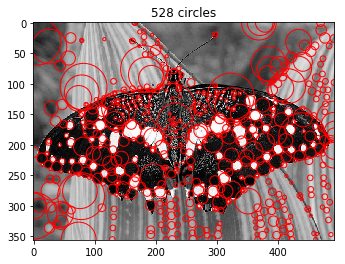

In [38]:
image_names = ['assignment2_images/butterfly.jpg', 'assignment2_images/einstein.jpg', 'assignment2_images/fishes.jpg', 'assignment2_images/sunflowers.jpg', 'assignment2_images/chess.jpg','assignment2_images/shanghai.jpg','assignment2_images/mountains.jpg','assignment2_images/andromeda.jpg']
k = 1.35
stds = [1.0 * (k ** i) for i in range(13)]
rads = [stds[i] * (2 ** 0.5) for i in range(len(stds))]

thresholds = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]


for i in range(len(image_names)):
    
    im = load_image(image_names[i])
    t = time.time()
    max_indices_condensed = blob_detector(im, stds, thresholds[i], k, 'increase_filter')
    print("Inefficient version on image %s ran in %f seconds." % (image_names[i], time.time()-t))
    (y,x) = indices = max_indices_condensed.nonzero()
    depths = max_indices_condensed[indices]
    my_stds = np.array([stds[depths[i]] for i in range(len(depths))])
    """
    blob_arr = np.stack([y,x,my_stds]).T
    
    new_blob_arr = skimage.feature.blob._prune_blobs(blob_arr, 0.7)
    
    (y, x, my_stds) = new_blob_arr.T
    my_rads = [my_stds[i] * (2 ** 0.5) for i in range(len(my_stds))]
    """
    
    my_rads = [rads[depths[i]] for i in range(len(depths))]
    show_all_circles(im, x, y, my_rads, image_names[i])


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Inefficient version on image assignment2_images/butterfly.jpg ran in 0.318321 seconds.


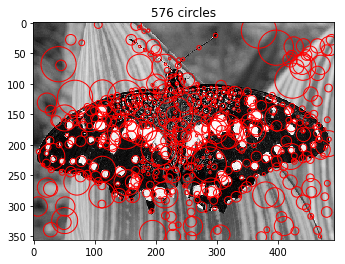

Inefficient version on image assignment2_images/einstein.jpg ran in 0.566436 seconds.


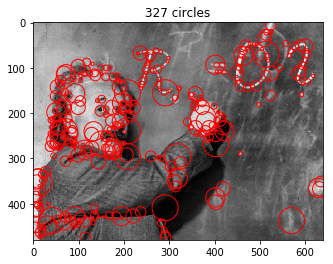

Inefficient version on image assignment2_images/fishes.jpg ran in 0.293725 seconds.


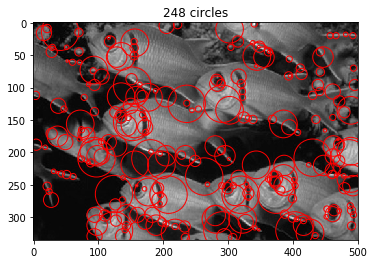

Inefficient version on image assignment2_images/sunflowers.jpg ran in 0.199370 seconds.


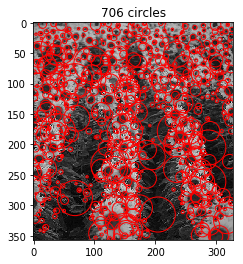

Inefficient version on image assignment2_images/chess.jpg ran in 0.707592 seconds.


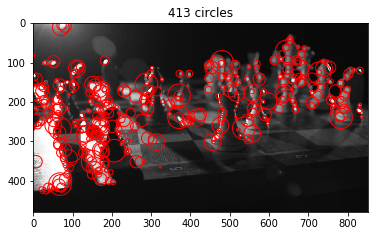

Inefficient version on image assignment2_images/shanghai.jpg ran in 0.607646 seconds.


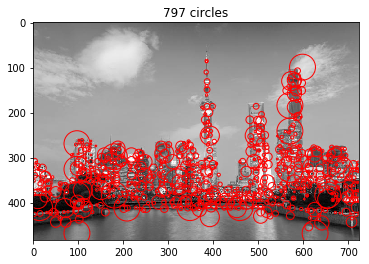

Inefficient version on image assignment2_images/mountains.jpg ran in 1.421621 seconds.


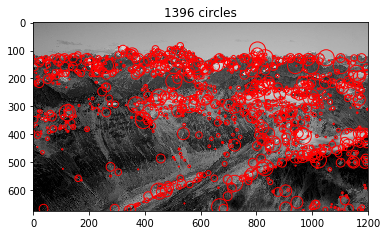

Inefficient version on image assignment2_images/andromeda.jpg ran in 4.780169 seconds.


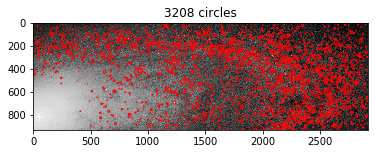

In [32]:
image_names = ['assignment2_images/butterfly.jpg', 'assignment2_images/einstein.jpg', 'assignment2_images/fishes.jpg', 'assignment2_images/sunflowers.jpg', 'assignment2_images/chess.jpg','assignment2_images/shanghai.jpg','assignment2_images/mountains.jpg','assignment2_images/andromeda.jpg']
k = 1.35
stds = [0.75 * (k ** i) for i in range(13)]
rads = [stds[i] * (2 ** 0.5) for i in range(len(stds))]

thresholds = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

for i in range(len(image_names)):
    im = load_image(image_names[i])
    t = time.time()
    max_indices_condensed = blob_detector(im, stds, thresholds[i], k, 'downsample')
    print("Inefficient version on image %s ran in %f seconds." % (image_names[i], time.time()-t))
    (y,x) = indices = max_indices_condensed.nonzero()
    depths = max_indices_condensed[indices]
    my_stds = np.array([stds[depths[i]] for i in range(len(depths))])
    
    my_rads = [rads[depths[i]] for i in range(len(depths))]
    show_all_circles(im, x, y, my_rads, image_names[i])